## main begins

In [1]:
from task1 import classify
from task1.sentiment import *
import numpy as np
# import classify

In [2]:
print("Reading data")
tarfname = "task2/data/sentiment.tar.gz"
sentiment = read_files(tarfname)
print("\nTraining classifier")

cls = classify.train_classifier(sentiment.trainX, sentiment.trainy)
print("\nEvaluating")
classify.evaluate(sentiment.trainX, sentiment.trainy, cls, 'train')
classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')

Reading data
-- train data
4582
-- dev data


There is ONE place in town to get a great croissant with

458
-- transforming data and labels

Training classifier

Evaluating
[[2118  173]
 [ 211 2080]]
  Accuracy on train  is: 0.9161938018332606
  F1 on train  is: 0.9154929577464789
[[180  49]
 [ 54 175]]
  Accuracy on dev  is: 0.7751091703056768
  F1 on dev  is: 0.7726269315673289


0.7751091703056768

In [3]:
print(len(sentiment.tfidf_vect.vocabulary_))
#print(len(sentiment.count_vect.idf_))
print(cls.coef_.shape)

9952
(1, 9952)


## bind tokens with idf and classifer weights

In [4]:
import operator
sorted(zip(sentiment.tfidf_vect.get_feature_names(), sentiment.tfidf_vect.idf_),
       key=operator.itemgetter(1))[::-1][:10]
idf_dict = dict(zip(sentiment.tfidf_vect.get_feature_names(), sentiment.tfidf_vect.idf_))

In [5]:
coef_dict = dict(zip(sentiment.tfidf_vect.get_feature_names(), cls.coef_.ravel()))

## frequencies of positive and negative reviews

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
print(len(sentiment.train_data_corr))
print(len(sentiment.train_data))
sentence_length = [len(l) for l in sentiment.train_data_corr]

# sentence length histograms
"""
seems that negative reviews are longer
"""
sentence_length_pos = [len(l) for t, l in zip(sentiment.trainy, sentiment.train_data_corr) if t == 1]
print('# positive reviews: %i' % len(sentence_length_pos))
sentence_length_neg = [len(l) for t, l in zip(sentiment.trainy, sentiment.train_data_corr) if t == 0]
print('# negative reviews: %i' % len(sentence_length_neg))
plt.hist((sentence_length_pos, sentence_length_neg), bins=20,
         label=['positive', 'negative'])
plt.yscale('log')
plt.legend()
plt.xlabel('Number of words in the review')
plt.ylabel('Number of reviews')
plt.show()

## most weighted tokens and their rareness

In [6]:
token_flat = [token for sent in sentiment.tfidf_vect.inverse_transform(sentiment.trainX) for token in sent]

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
c = Counter(token_flat)
common_tokens, _ = zip(*c.most_common(100))
# for t in common_tokens:
#     print(t, idf_dict[t], coef_dict[t])
common_tokens = [token for token, count in c.most_common() if count>10]
common_tokens_idf = [idf_dict[t] for t in common_tokens]
common_tokens_coef = [coef_dict[t] for t in common_tokens]

('worst', 'horrible', 'amazing', 'great', 'delicious', 'excellent', 'awesome', 'best', 'terrible', 'rude', 'love', 'favorite', 'disappointing', 'wonderful', 'perfect', 'bad', 'asked', 'friendly', 'average', 'disappointed')


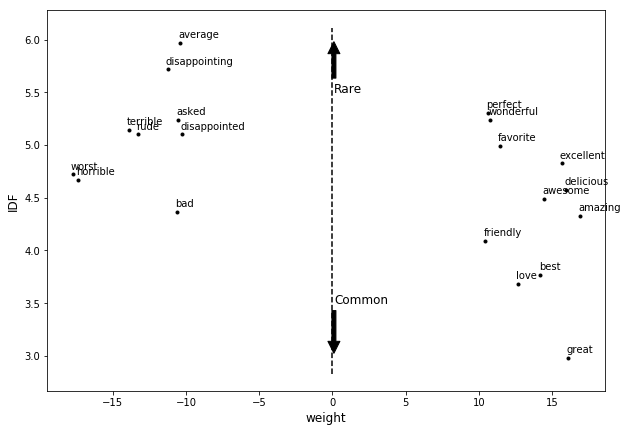

In [8]:
%matplotlib inline
#notebook
common_tokens_weight = [(t, idf_dict[t] * coef_dict[t]) for t in common_tokens]
top_weighted_tokens = sorted(common_tokens_weight, key=lambda x: abs(x[1]))[::-1][:20]
top_tokens, weights = zip(*top_weighted_tokens)
print(top_tokens)
x = weights
y = [idf_dict[t] for t in top_tokens] #[coef_dict[t] for t in top_tokens]

plt.figure(figsize=(10,7))
plt.plot(x, y , 'k.')
plt.plot([0,0], plt.ylim(), 'k--')
for i, t in enumerate(top_tokens):
    anchor = (x[i]-0.12, y[i]+0.05)
#     if t == 'rude':
#         anchor = (anchor[0]+0.1, anchor[1]-0.15)
#     if t == 'disappointed':
#         anchor = (anchor[0]+0.1, anchor[1]-0.2)
#     if t == 'disappointing':
#         anchor = (anchor[0]+0.1, anchor[1]-0.2)
#     if t == 'average':
#         anchor = (anchor[0]+0.15, anchor[1]-0.05)
    plt.annotate(t, anchor)
    
plt.xlabel('weight', fontsize=12)
plt.ylabel('IDF', fontsize=12)
plt.annotate('Rare', xy=(0.1, 6.0), xytext=(0.1, 5.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.annotate('Common', xy=(0.1, 3.0), xytext=(0.1, 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
plt.show()

# about confidence (probability of prediction)

In [9]:
probs = np.max(cls.predict_proba(sentiment.devX), axis=1)
print(len(probs))

458


## the most confident but incorrect example

Having trouble on what to have for dinner and have a big appetite, Check out this place The desserts are great and so is the fresh food. I love coming 0 1
sum of weights:  46.8820393060153
[0.14133326 0.85866674]


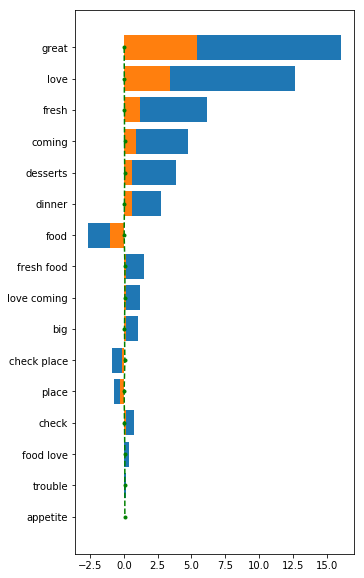

In [10]:
ind_prob = list(enumerate(probs))
targets = sentiment.devy
preds = cls.predict(sentiment.devX)
false_inds = np.argwhere(targets != preds).ravel()
ind_, _ = sorted(zip(false_inds, probs[false_inds]),
                 key=operator.itemgetter(1))[::-1][0]
print(sentiment.dev_data[ind_], targets[ind_], preds[ind_])

token_weight = sorted([(token, idf_dict[token]*coef_dict[token]) for token in sentiment.tfidf_vect.inverse_transform(sentiment.devX[ind_])[0]], key=lambda x: abs(x[1]))[::-1]
# print(token_weight)

tokens, weights = zip(*token_weight)
print('sum of weights: ', sum(weights))
print(cls.predict_proba(sentiment.devX[ind_])[0])

plt.figure(figsize=(5,10))
plt.barh(y=range(len(weights))[::-1], width=weights, 
         tick_label=tokens)
plt.barh(y=range(len(weights))[::-1], width=[coef_dict[token] for token in tokens])
plt.plot([idf_dict[token]/100 for token in tokens], range(len(weights))[::-1], '.--', color='green')

## most confident examples

In [11]:
inds, _ = zip(*sorted(ind_prob, key=lambda x:x[1])[::-1][:5])

In [12]:
for i in inds:
    print(sentiment.dev_data[i],
          cls.predict(sentiment.devX[i]),
          sentiment.dev_labels[i], end='\n---\n')

I love this place. They have great breakfast treats and great lunches not to mention the amazing sweets!! Also they have homemade icecream with moose tracks. YUM I like to [1] POSITIVE
---
Quick -fresh-delicious!Great curries and Thai basilThe Green Curry with Chicken is a favorite! [1] POSITIVE
---
Worst Mexican place ever!!!! Their chicken is horrible pink not fully cooked!!! Had the chicken enchilada 's and had horrible food poisoning out both ends. The bartender was rude! The [0] NEGATIVE
---
Great selection of tropical and traditional ice cream flavors. Tastes fresh, natural and not too sweet. Got a few fresh baked cookies to add to our dessert. Delicious dessert, friendly [1] POSITIVE
---
A Savory Affair catered my daughters wedding this weekend and they did an amazing job! The food was absolutely delicious and they were punctual, friendly, helpful and professional. Many people [1] POSITIVE
---


## least confidence examples

In [13]:
inds, _ = zip(*sorted(ind_prob, key=lambda x:x[1])[:5])
for i in inds:
    print(sentiment.dev_data[i],
          cls.predict(sentiment.devX[i]),
          sentiment.dev_labels[i], end='\n---\n')
"""
Mostly contains 'but' or other adversatives. indicates a turn in meaning
use LIME to analyze these examples to show more
"""

As my tip states, you'll be lucky if you get Jenny as your bartender. That girl seriously knows what she's doing and puts most other Vegas bartenders to shame. After [1] POSITIVE
---
Had an awsome late lunch at this bbq restaurant this afternoon.  I have a gluten alergy so it was a relief to be able to talk to the owner [0] POSITIVE
---
I had the day off and was planning on getting my hair done, running errands, and later pick up my kids from school. It took the stylist FOUR HOURS for [0] NEGATIVE
---
First off, good service. Waitress was very friendly and honest. Anyways, I wanted some ramen this evening. Strolled in to find that today there was some ramen with chicken in [0] NEGATIVE
---
What a disappointment!  This is only the second buffet I've eaten at in Vegas but it pales in comparison to the Bellagio.  The food wasn't that fresh, service [1] NEGATIVE
---


"\nMostly contains 'but' or other adversatives. indicates a turn in meaning\nuse LIME to analyze these examples to show more\n"

## how performance relates to confidence

In [ ]:
probs = np.max(cls.predict_proba(sentiment.devX), axis=1)

bin_bound = np.linspace(0.5, 1, 10)
bin_x = (bin_bound[:-1] + bin_bound[1:])/2
digits = np.digitize(probs, bin_bound)
from collections import defaultdict
bin_inds = defaultdict(list)
for i, i_bin in enumerate(digits):
    bin_inds[i_bin].append(i)

from sklearn.metrics import precision_score, recall_score
def precision_recall(targets, preds):
    precision = precision_score(targets, preds)
    assert(precision == sum((preds == targets) * preds) / sum(preds))
    recall = recall_score(targets, preds)
    assert(recall == sum((preds == targets) * preds) / sum(targets))
    return precision, recall

In [ ]:
stats = []
for i_bin in bin_inds:
    targets = sentiment.devy[bin_inds[i_bin]]
    preds = cls.predict(sentiment.devX[bin_inds[i_bin]])
    stats.append((bin_x[i_bin-1],
                  len(bin_inds[i_bin]),
                  precision_recall(targets, preds)))

In [ ]:
probs = np.max(cls.predict_proba(sentiment.trainX), axis=1)

bin_bound = np.linspace(0.5, 1, 10)
bin_x = (bin_bound[:-1] + bin_bound[1:])/2
digits = np.digitize(probs, bin_bound)
from collections import defaultdict
bin_inds = defaultdict(list)
for i, i_bin in enumerate(digits):
    bin_inds[i_bin].append(i)

from sklearn.metrics import precision_score, recall_score
def precision_recall(targets, preds):
    precision = precision_score(targets, preds)
    assert(precision == sum((preds == targets) * preds) / sum(preds))
    recall = recall_score(targets, preds)
    assert(recall == sum((preds == targets) * preds) / sum(targets))
    return precision, recall

In [ ]:
stats = []
for i_bin in bin_inds:
    targets = sentiment.trainy[bin_inds[i_bin]]
    preds = cls.predict(sentiment.trainX[bin_inds[i_bin]])
    stats.append((bin_x[i_bin-1],
                  len(bin_inds[i_bin]),
                  precision_recall(targets, preds)))

In [ ]:
bin_x_, count, p_r = zip(*sorted(stats))
precision, recall = zip(*p_r)
assert np.all(bin_x == bin_x_)
fig, ax = plt.subplots()
ax.bar(x=bin_x, height=count, width=0.05, color='green',
       label='count')
ax1 = ax.twinx()
ax1.plot(bin_x, precision, '.-', label='precision')
ax1.plot(bin_x, recall, '.-', label='recall')
ax1.legend()
ax.legend(loc='upper center')
ax.set_xlabel('Probability of prediction')
ax1.plot(ax1.get_xlim(), [0.5, 0.5], 'k--')
ax1.annotate('random guessing',
             xy=(0.9, 0.5), xytext=(0.8, 0.6),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
"""
weird behaviour around 0.5 bin
"""

In [ ]:
precision_recall(sentiment.trainy,
                 np.random.choice([0,1], len(sentiment.trainy)))